In [11]:
from pynq import  DefaultHierarchy
from pynq import allocate
from math import log
import numpy as np
class FFT_Block_Driver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)
        self.configuration = 0
        self.fft_size = 0
    
    def convert_to_data(self, fft_direction, size):
        fft_direction = fft_direction.zfill(8)  
        byte2 = '0' * 8
        
        x = int(log(size, 2))
        fft_size = bin(x)[2:].zfill(8)  
        
        tdata = fft_direction + byte2 + fft_size
        return int(tdata, 2)
    
    def configure(self, fft_direction, fft_size):
        self.configuration = self.convert_to_data(fft_direction, fft_size)
        temp = allocate(1, np.uint32)
        temp[0] = self.configuration
        self.config_dma.sendchannel.transfer(temp)
        self.config_dma.sendchannel.wait()
        del temp
    
    def stream_fft(self, input_buffer):
        out_buffer = allocate(SAMPLES, np.csingle)
        self.data_dma.sendchannel.transfer(input_buffer)
        self.data_dma.recvchannel.transfer(out_buffer)
        self.data_dma.sendchannel.wait()
        self.data_dma.recvchannel.wait()
        return out_buffer
    
    @staticmethod
    def checkhierarchy(description):
        if 'data_dma' in description['ip'] and 'config_dma' in description['ip']:
            print("Checking hierarchy")
            return True
        return False

              
            
            
            
        
    

In [12]:
from pynq import Overlay
ol= Overlay('recon_fft.bit')

 

Checking hierarchy


In [13]:
ol?

In [14]:
fft=ol.fft_block

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [16]:
SAMPLES =1024

In [17]:
time_interval = 1
def create_data(SAMPLES,time_interval):
    A1= random.uniform(100,1000)
    A2= random.uniform(100,1000)
    A3 = random.uniform(100,1000)
    f1= random.uniform(100,150)
    f2= random.uniform(200,300)
    f3= random.uniform(500,600)
    w1= 2*np.pi*f1
    w2= 2*np.pi*f2
    w3= 2*np.pi*f3
    t= np.linspace(0,time_interval,SAMPLES)
    data= A1*np.sin(w1*t,dtype=np.csingle) + A2*np.sin(w2*t,dtype=np.csingle)+ A3*np.sin(w3*t,dtype=np.csingle)
    return data,t

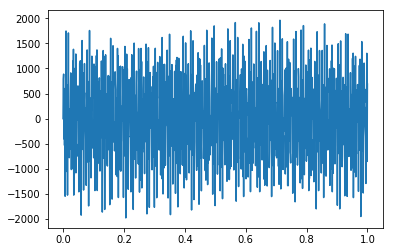

In [18]:
data,t= create_data(SAMPLES,time_interval)
plt.plot(t,np.real(data))

In [19]:
%%time
output = np.fft.fft(data)

CPU times: user 2.63 ms, sys: 211 µs, total: 2.84 ms
Wall time: 1.59 ms


In [20]:
input_buffer= allocate(SAMPLES,np.csingle)

In [21]:
np.copyto(input_buffer,data)

In [22]:
fft.configure('1',SAMPLES)

In [23]:
output_hw = fft.stream_fft(input_buffer)

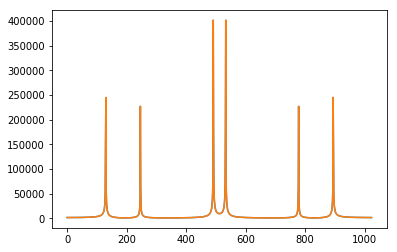

In [24]:
plt.plot(np.abs(output))
plt.plot(np.abs(output_hw))

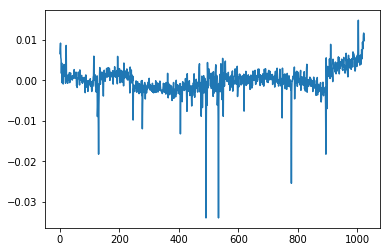

In [25]:
plt.plot(np.abs(output)-np.abs(output_hw))